In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def gauss(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

def line(x,a,b):
    return a*x+b

def line_vbd(x,a,vbd):
    return a*(x-vbd)

def expo_pulse(x,a1,tau1,a2,tau2):
    return a1*np.exp(-(x-750)/tau1)+a2*np.exp(-(x-750)/tau2)

In [4]:
def AR_filter(wf, tau):
    if wf.shape[0]>1:#multiple waveforms
        wf = wf.transpose()
    wf_filt = np.zeros(wf.shape)
    for i,raw in enumerate(list(reversed(wf))):
        if i>0:
            wf_filt[i] = raw + wf_filt[i-1]*np.exp(-1/tau)
        else:
            wf_filt[i] = raw
    return np.array(list(reversed(wf_filt))).transpose()

# Scintillation data top 1004

## Directory

In [5]:
dir = "/home/aj9512/jadwin-365/data/sipm/reflector_studies/20221004/20221004_60V_scint_top/"

## SPE charge from calibration

In [6]:
gain_top = [263.83304269154604, 225.54550142289833, 246.43480002250982, 216.58835157109758]

ch0
  TRIGGER POSITION = SAMPLE 801
ch1
  TRIGGER POSITION = SAMPLE 799
ch2
  TRIGGER POSITION = SAMPLE 801
ch3
  TRIGGER POSITION = SAMPLE 798


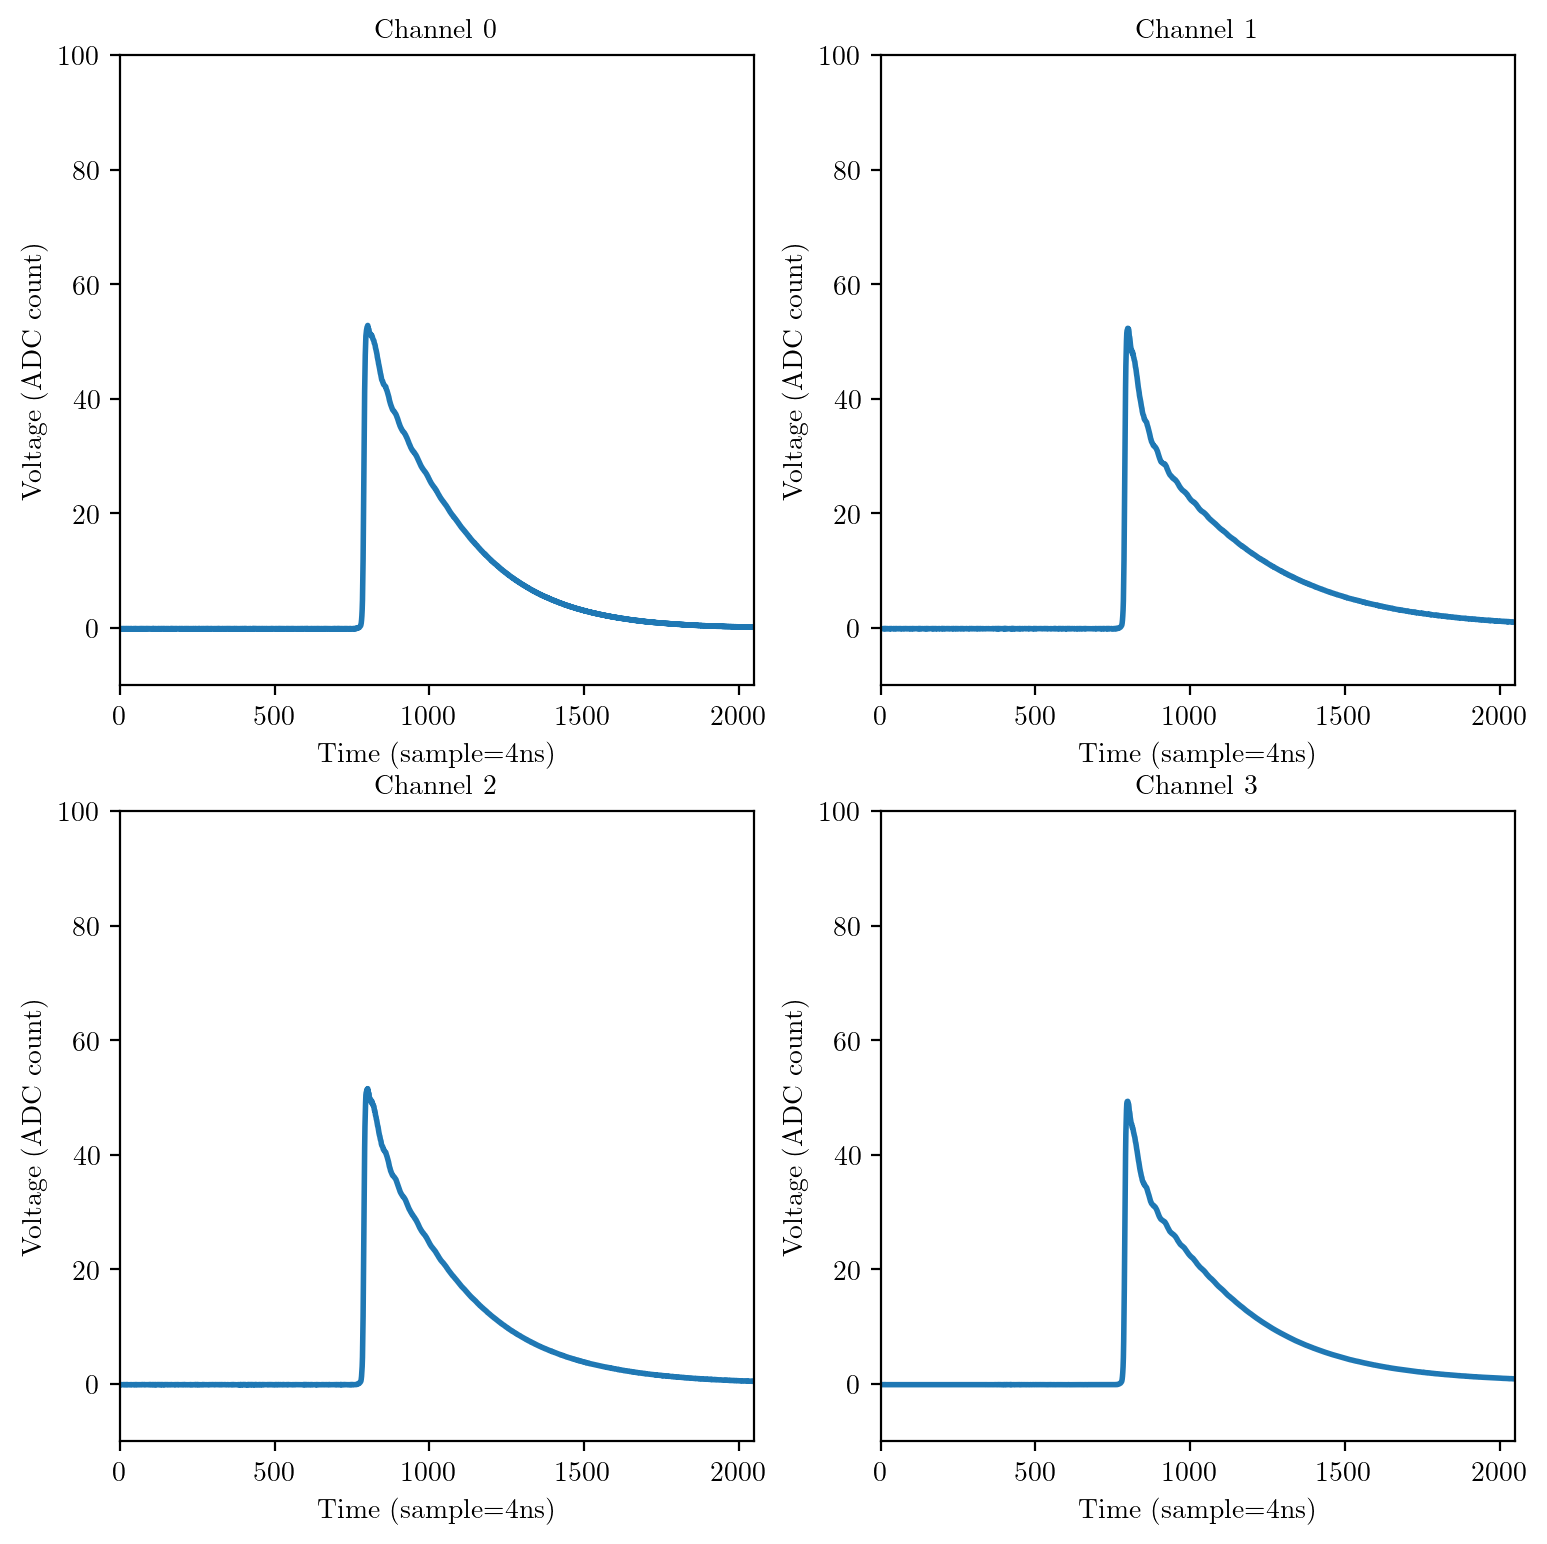

In [9]:
#waveform length in samples
length = 2048
#total events
nevents = 100000
#pretrigger baseline length
bsl_length = 790
#charge histogram
nbins_charge = 500
h_charge_ch = np.zeros((4,nbins_charge))
h_charge_bincent_ch = np.zeros((4,nbins_charge))
h_charge_binwid_ch = np.zeros((4))
#charge integral range
tmin = 790
tmax = 2000
#average waveform
avgwf_ch = np.zeros((4,length))
avgwf_sample_ch = np.zeros((4,length))
#for average waveforms
plt.figure(0,figsize=(9,9))
#charge in units of pe
integrals_pe = np.zeros((4,nevents))
#sum of charge
integrals_pe_sum = np.zeros((nevents))
h_charge_sum = np.zeros((nbins_charge))
h_charge_bincent_sum = np.zeros(nbins_charge)
h_charge_binwid_sum = 0

for ch in [0,1,2,3]:
    print("ch{}".format(ch))
    fname = "{}wave{}.dat".format(dir,ch)
    dt = np.dtype('<H')
    file = open(fname, 'rb')
    traces = np.fromfile(file, dtype=dt, count=-1)
    file.close()

    traces = traces.reshape((-1,length)).astype(float)
    traces = np.tile(np.mean(traces[:,:bsl_length],axis=1).reshape(nevents,1),(1,length)) - traces
    integrals_pe[ch] = np.sum(traces[:,tmin:tmax],axis=1)/gain_top[ch]
    
    #charge histogram
    h_charge_ch[ch], bin_edges = np.histogram(integrals_pe[ch], bins=np.linspace(0, 2e3, nbins_charge+1))#linspace(min, max, nbins+1)
    h_charge_bincent_ch[ch] = (bin_edges[1:]+bin_edges[:-1])/2
    h_charge_binwid_ch[ch] = bin_edges[1]-bin_edges[0]

    # spe average waveform
    # not implemented yet. for now average over all waveforms
    count = 0
    meanwf = np.mean(traces,axis=0)
    for wf_sub_bsl in traces:
        avgwf_ch[ch] = avgwf_ch[ch]*count + wf_sub_bsl
        count += 1
        avgwf_ch[ch] = avgwf_ch[ch]/count
    trig_pos = np.argmax(avgwf_ch[ch])
    print('  TRIGGER POSITION = SAMPLE {}'.format(trig_pos))
    plt.figure(0)
    plt.subplot(2,2,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Voltage (ADC count)')
    plt.xlabel('Time (sample=4ns)')
    plt.plot(meanwf)
    plt.xlim(0,2048)
    plt.ylim(-10, 100)
    
integrals_pe_sum = np.sum(integrals_pe, axis=0)
h_charge_sum, bin_edges = np.histogram(integrals_pe_sum, bins=np.linspace(0, 2e3, nbins_charge+1))#linspace(min, max, nbins+1)
h_charge_bincent_sum = (bin_edges[1:]+bin_edges[:-1])/2
h_charge_binwid_sum = bin_edges[1]-bin_edges[0]

## Plot charge histogram and analyze

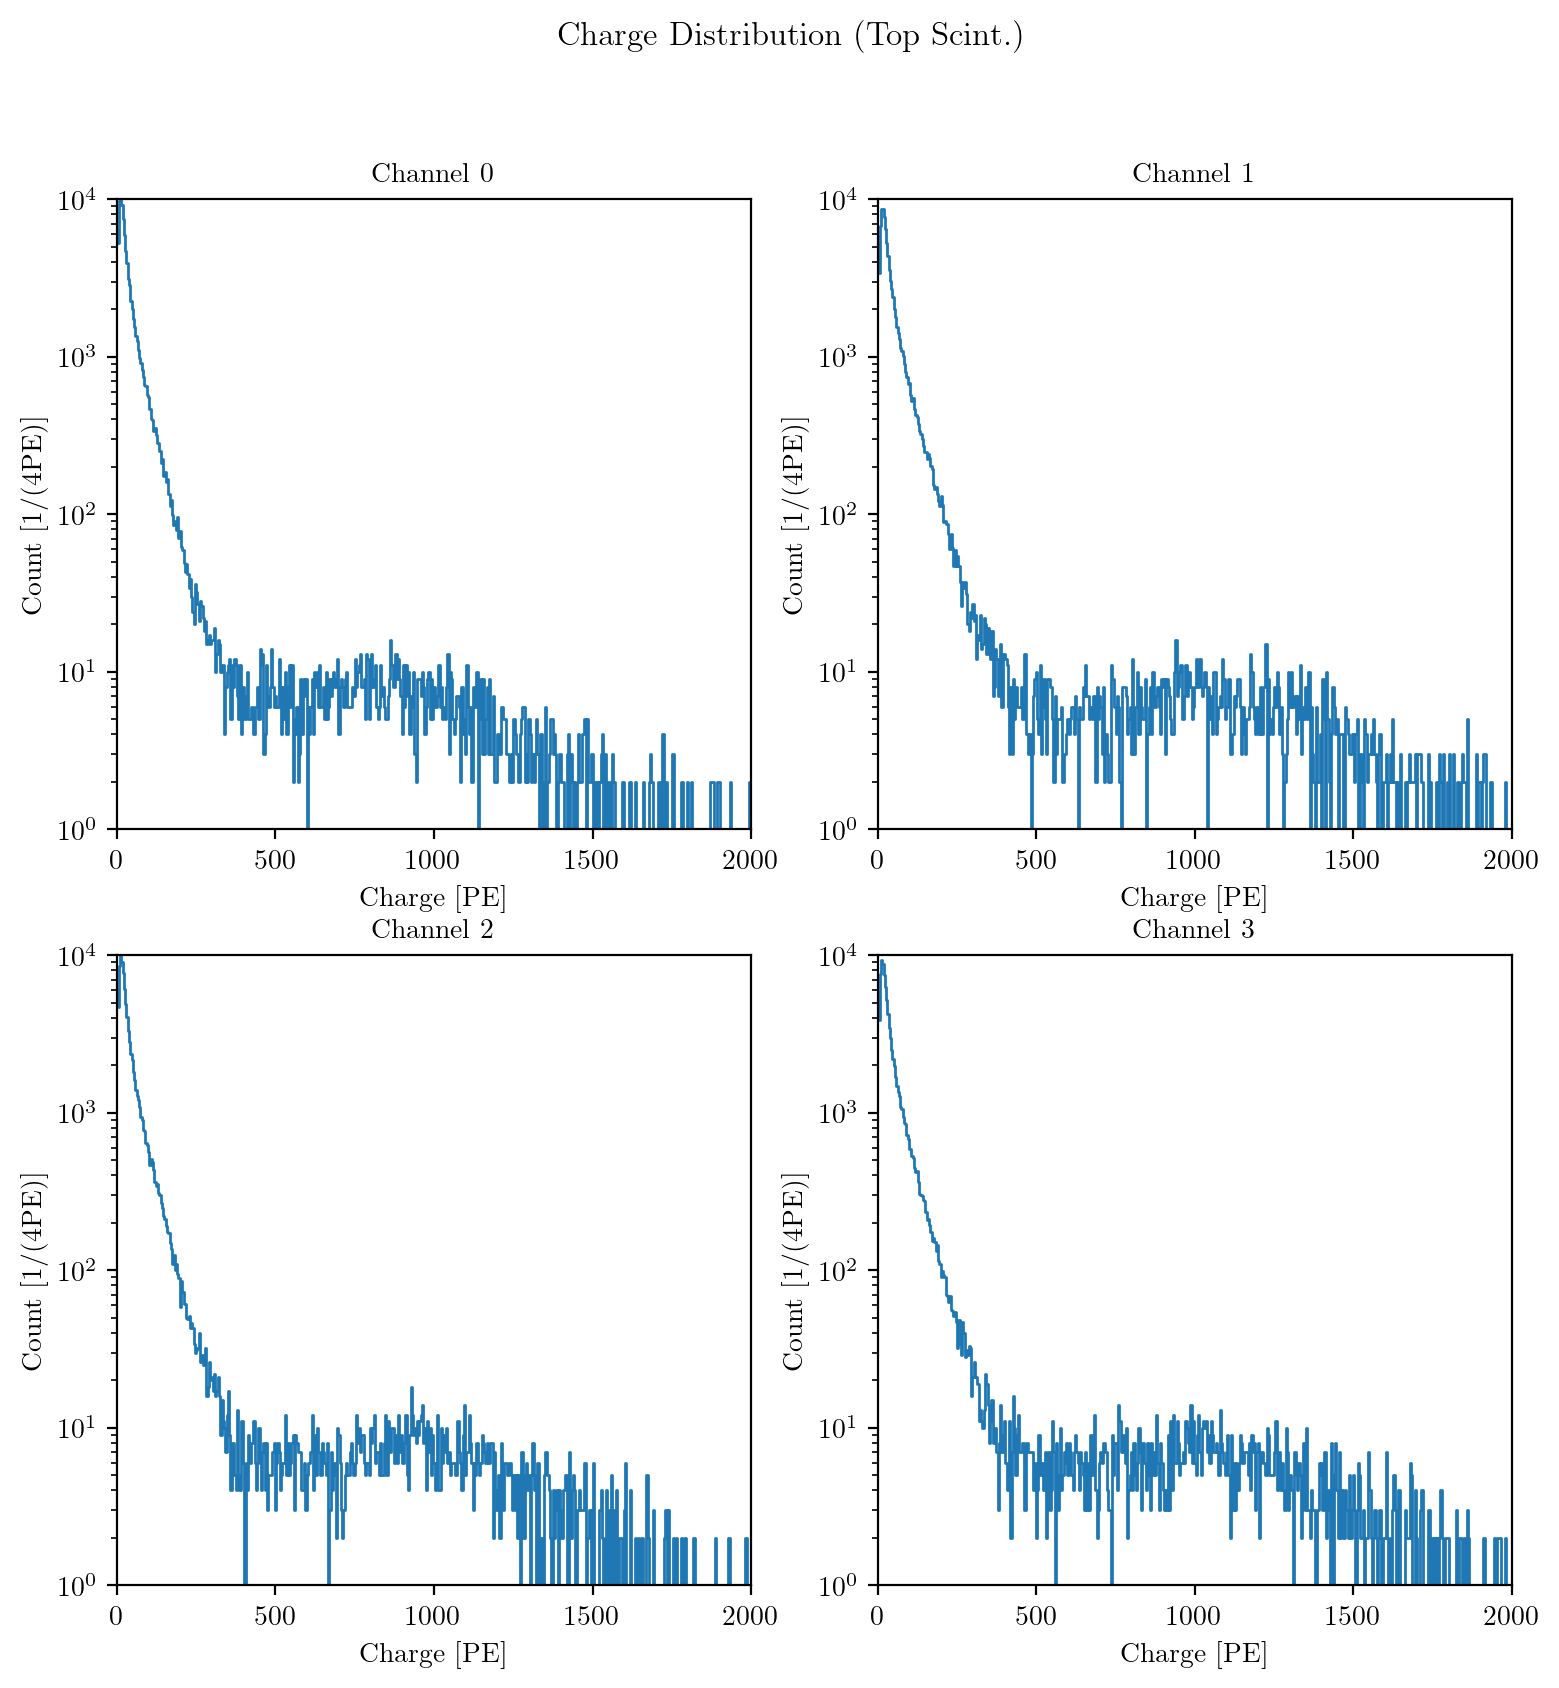

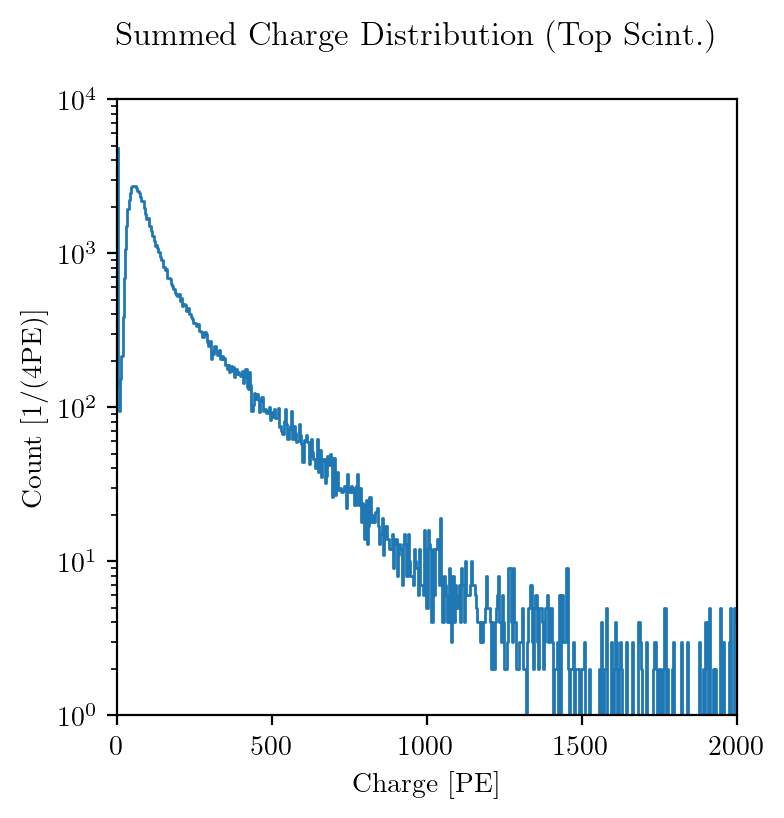

In [11]:
plt.figure(0,figsize=(9,9))#for charge histograms
for ch in range(4):
    #charge histogram
    plt.figure(0)
    plt.subplot(2,2,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.step(h_charge_bincent_ch[ch], h_charge_ch[ch], linewidth=1)
    plt.yscale('log')
    plt.xlim(0, 2e3)
    plt.ylim(1, 1e4)
    plt.ylabel('Count [1/(4PE)]')
    plt.xlabel('Charge [PE]')
        
plt.figure(0)
plt.suptitle('Charge Distribution (Top Scint.)')
plt.savefig('/home/as111/sipm-analysis/plots/sipm/charge_histo_top_scint_1004.pdf')

plt.figure(1,figsize=(4,4))#for summed charge histograms
plt.suptitle('Summed Charge Distribution (Top Scint.)')
plt.step(h_charge_bincent_sum, h_charge_sum, linewidth=1)
plt.yscale('log')
plt.xlim(0, 2e3)
plt.ylim(1, 1e4)
plt.ylabel('Count [1/(4PE)]')
plt.xlabel('Charge [PE]')
plt.savefig('/home/as111/sipm-analysis/plots/sipm/charge_histo_top_scint_sum_1004.pdf')